# Random Forest Classification


## Data Preprocessing


In [147]:
dataset_path = '../Datasets/SVM-main-data/Social_Network_Ads.csv'


In [148]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


### Loading the data


In [149]:
data = pd.read_csv(dataset_path).drop(columns=['User ID'])
data.head(n=5)


,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


In [150]:
data.shape


(400, 4)

### One Hot Encoding


In [151]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

categorical_columns = ['Gender']

# Fit the encoder
encoded_data = encoder.fit_transform(data[categorical_columns])

# Convert the encoded data to a new dataframe
encoded_df = pd.DataFrame(encoded_data.toarray(
), columns=encoder.get_feature_names_out(categorical_columns))

# convert from float to int
encoded_df = encoded_df.astype(int)

# Concatenate the encoded dataframe with the original dataframe
new_data = pd.concat([data, encoded_df], axis=1)

# Drop the original categorical columns (string columns)
new_data.drop(categorical_columns, axis=1, inplace=True)


### Count the values of 'Purchased'


In [152]:
new_data['Purchased'].value_counts()


0    257
1    143
Name: Purchased, dtype: int64

## Up-Sampling

In [153]:
# balance the dataset
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = new_data[new_data['Purchased'] == 0]
df_minority = new_data[new_data['Purchased'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                    replace=True,  # sample with replacement
                                    n_samples=257,  # to match majority class
                                    random_state=123)

new_data = pd.concat([df_majority, df_minority_upsampled])


## Down-Sampling

In [154]:
# # balance the dataset
# from sklearn.utils import resample

# # Separate majority and minority classes
# df_majority = new_data[new_data['Purchased'] == 0]
# df_minority = new_data[new_data['Purchased'] == 1]

# # Downsample majority class
# df_majority_downsampled = resample(df_majority,
#                                    replace=False,  # sample without replacement
#                                    n_samples=143,  # to match minority class
#                                    random_state=123)


# new_data = pd.concat([df_majority_downsampled, df_minority])


In [155]:
new_data['Purchased'].value_counts()

0    143
1    143
Name: Purchased, dtype: int64

In [156]:
new_data.head(n=5)


,Age,EstimatedSalary,Purchased,Gender_Female,Gender_Male
44,28,84000,0,1,0
120,36,75000,0,1,0
110,39,71000,0,1,0
246,35,50000,0,1,0
248,41,52000,0,0,1


### Check for missing values


In [157]:
new_data.isnull().sum()


Age                0
EstimatedSalary    0
Purchased          0
Gender_Female      0
Gender_Male        0
dtype: int64

### Correlation Matrix


In [158]:
# get the correlation matrix
corr_matrix = new_data.corr()[['Purchased']].sort_values(
    by='Purchased', ascending=False)


# display the correlation matrix with a heatmap
corr_matrix.style.background_gradient(cmap='coolwarm')


,Purchased
Purchased,1.000000
Age,0.644517
EstimatedSalary,0.333949
Gender_Female,0.048970
Gender_Male,-0.048970


# Build the model


## Spliting the data


In [159]:
# split the data into train and test
from sklearn.model_selection import train_test_split

target = 'Purchased'
X = new_data.drop(columns=target)
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [160]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (228, 4)
X_test shape: (58, 4)
y_train shape: (228,)
y_test shape: (58,)


## Create the Random Forest Classifier


In [161]:
# create the radom forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=4, random_state=42)


In [162]:
# fit the model on the training data
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=4, random_state=42)

## Test the model


In [163]:
model.score(X_test, y_test)


0.8103448275862069

In [164]:
# make predictions on the test data
y_pred = model.predict(X_test)


### Confusion Matrix


In [165]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# display the confusion matrix as a table with labels
pd.DataFrame(cm, index=['Actual 0', 'Actual 1'],
             columns=['Predicted 0', 'Predicted 1'])


,Predicted 0,Predicted 1
Actual 0,21,3
Actual 1,8,26


### Visualize the accuracy

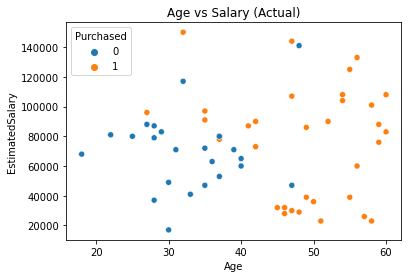

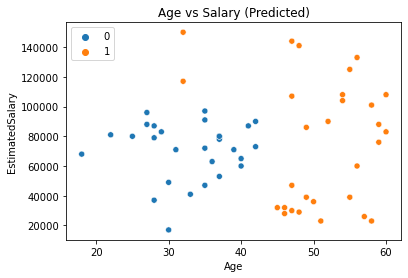

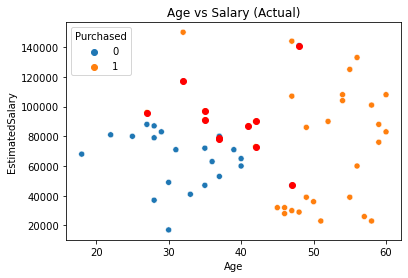

In [166]:
import seaborn as sns

sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_test, data=X_test)
plt.title('Age vs Salary (Actual)')
plt.show()

sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_pred, data=X_test)
plt.title('Age vs Salary (Predicted)')
plt.show()

# highlight the misclassified points
sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_test, data=X_test)
plt.scatter(X_test[y_test != y_pred]['Age'],
            X_test[y_test != y_pred]['EstimatedSalary'], color='red')
plt.title('Age vs Salary (Actual)')
plt.show()

### Classification Report


In [167]:
# get the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
      target_names=['Not Purchased', 'Purchased']))


               precision    recall  f1-score   support

Not Purchased       0.72      0.88      0.79        24
    Purchased       0.90      0.76      0.83        34

     accuracy                           0.81        58
    macro avg       0.81      0.82      0.81        58
 weighted avg       0.83      0.81      0.81        58



### Important Features


In [168]:
# analyze the feature importances
importances = model.feature_importances_

# display the relative importance of each feature
pd.DataFrame(data=importances, index=X_train.columns, columns=['Importance']).sort_values(
    by='Importance', ascending=False)


,Importance
Age,0.599703
EstimatedSalary,0.395372
Gender_Male,0.002848
Gender_Female,0.002077


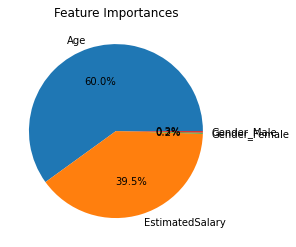

In [169]:
# visualize the feature importances in a pie chart
plt.pie(importances, labels=X_train.columns, autopct='%1.1f%%')
plt.title('Feature Importances')
plt.show()
